In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from tabulate import tabulate
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
filePath = '/content/drive/My Drive/APS360'
os.chdir(filePath)

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
hamExists = False
spamExists = False

for line in open('SMSSpamCollection'):
    label, msg = line.split('\t')

    if label == 'ham' and not hamExists:
        print(f"[HAM] {msg}")
        hamExists = True

    if label == 'spam' and not spamExists:
        print(f"[SPAM] {msg}")
        spamExists = True

    if spamExists and hamExists:
        break

[HAM] Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

[SPAM] Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('SMSSpamCollection'):
    label, msg = line.split('\t')
    if label == 'ham':
        ham += 1
    else :
        spam+=1

print( tabulate([[spam,ham]], headers=('spam', 'ham')) )

  spam    ham
------  -----
   747   4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

> Advantages

* Can be used for more languages
* Smaller vocabulary

> Disadvantages

* Slower to train
* Larger vocabulary


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext
import random

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If the training data consists of more ham messages, then the model would be biased towards labeling msges as ham (thereby having more false negatives). This is because in the training data, it is more likely that a sample is ham than spam.

This may be helpful, as sometimes we do want a bias. For example, misclassifying a spam email as ham is less harmful than misclassifying ham email as spam. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
# text_field.vocab.stoi
# text_field.vocab.itos



*   **stoi**: a mapping of the character to a numeric identifier
*   **itos**: a list of characters that can be accessed by indexing its numeric identifier in stoi



### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?



*   **unk**: replaces rare characters that do not fit in the vocabulary
*   **pad**: padding used to ensure all characters in the batch are the same length 



### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
for batch in train_iter:
    pads = torch.empty(32).fill_(len(batch.sms[0][0])) -  batch.sms[1]
    print(f"[BATCH {i}] [MAX SEQUENCE LEN {len(batch.sms[0][0])}] [PADS {pads.sum()}]")

    i+=1
    if i == 10:
        break

[BATCH 0] [MAX SEQUENCE LEN 156] [PADS 0.0]
[BATCH 1] [MAX SEQUENCE LEN 76] [PADS 57.0]
[BATCH 2] [MAX SEQUENCE LEN 15] [PADS 203.0]
[BATCH 3] [MAX SEQUENCE LEN 154] [PADS 16.0]
[BATCH 4] [MAX SEQUENCE LEN 34] [PADS 30.0]
[BATCH 5] [MAX SEQUENCE LEN 24] [PADS 28.0]
[BATCH 6] [MAX SEQUENCE LEN 39] [PADS 20.0]
[BATCH 7] [MAX SEQUENCE LEN 144] [PADS 19.0]
[BATCH 8] [MAX SEQUENCE LEN 32] [PADS 4.0]
[BATCH 9] [MAX SEQUENCE LEN 31] [PADS 4.0]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SmsRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SmsRNN, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        # out = self.fc(out[:, -1, :])
        out = self.fc(torch.max(out, dim=1)[0])
        # out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    bs: batch size
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data:
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.label.shape[0]
    
    return round(correct/total, 4)


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def get_data_iters(data, batchsize):
    return torchtext.data.BucketIterator(data,
                                           batch_size=batchsize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


In [ ]:
def plot(loss, trainAcc, validAcc):
    xAxis = np.arange(1, len(loss) + 1).tolist()

    # Loss
    plt.title("Loss")
    plt.plot(xAxis, loss, label="Training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Acc
    plt.title("Accuracy")
    plt.plot(xAxis, trainAcc, label="Training")
    plt.plot(xAxis, validAcc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def train_RNN(model, train, valid, epochs, lr, bs):
    trainIter = get_data_iters(train, bs)
    validIter = get_data_iters(valid, bs)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, trainAcc, validAcc = [], [], []

    for epoch in range(epochs):
        for batch, i in zip(trainIter, range(bs)):
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()
        
        losses.append(round(loss.item(),4))
        trainAcc.append( get_accuracy(model, trainIter) ) 
        validAcc.append( get_accuracy(model, validIter) )

        print(f"[EPOCH {epoch}] Loss : {losses[-1]}   TrainAcc : {trainAcc[-1]}   ValidAcc : {validAcc[-1]}")
    
    plot(losses, trainAcc, validAcc)

In [ ]:
model = SmsRNN(len(text_field.vocab), len(text_field.vocab), 2)
epochs = 200
lr = 1e-5
bs = 32
train_RNN(model, train, valid, epochs, lr, bs)

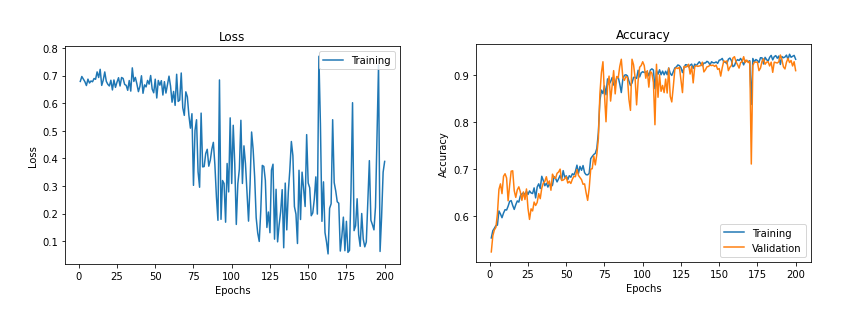

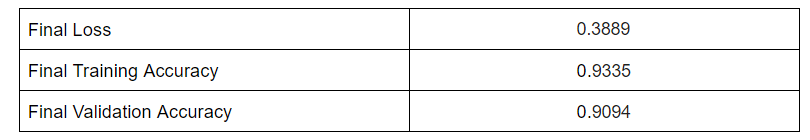

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.




> Epochs : 175

> Learning rate : 1e-4


> RNN output : out = self.fc(torch.max(out, dim=1)[0])



> Batch Size : 128



First, I tested different learning rates in combination with different RNN outputs. The highest validation scores are highlighted

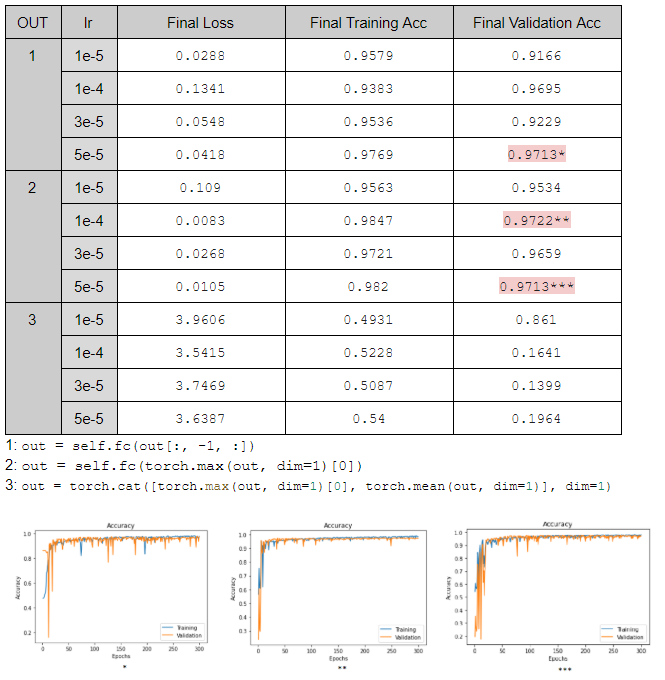

From the three configurations that yielded the highest validation accuracy, I examined the accuracy curves to see which one is the most "smooth", so that the accuracy would be consistent from epoch to epoch. This led me to choose option **.

Taking that configuration, I tested which batch size produced the best results. Which led me to settle on a batch size of 128.

Finally, I trained the model for 500 epochs to see at which point to stop training. I noticed that beyond approximately 150 epochs, the validation accuracy remained at a similar value. So I decided to train for 175 epochs.

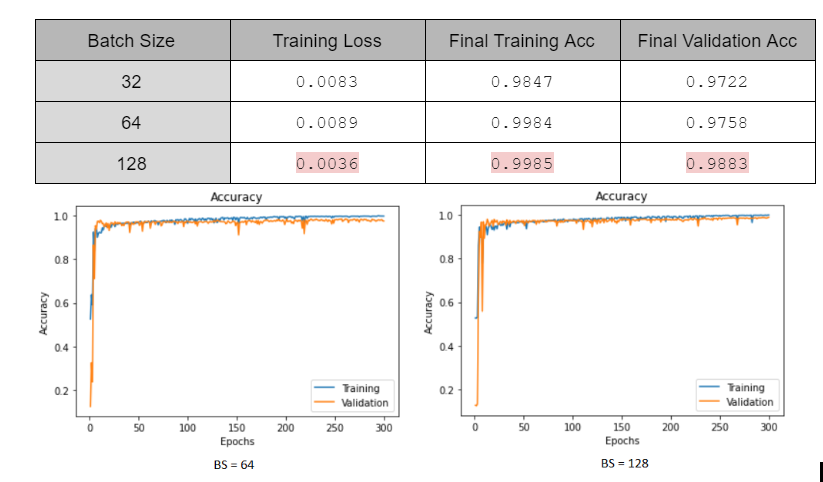

In [ ]:
model = SmsRNN(len(text_field.vocab), len(text_field.vocab), 2)
epochs = 175
lr = 1e-4
bs = 128
train_RNN(model, train, valid, epochs, lr, bs)

**Final Accuracies**

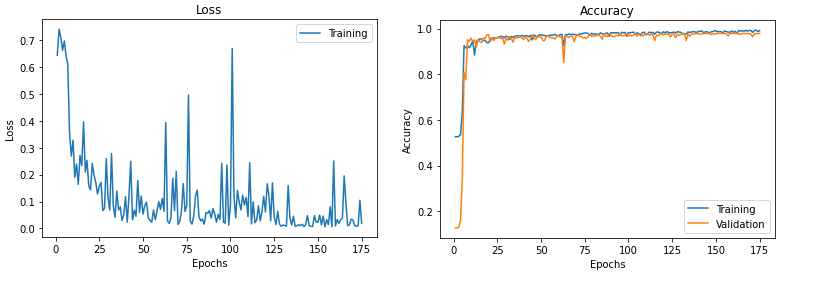

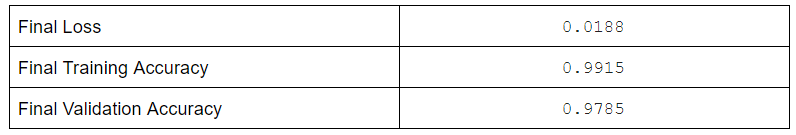

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

# False positive: ham labeled as spam
valid_nospam = get_data_iters(valid_nospam, 128)
falsePositive = (1-get_accuracy(model, valid_nospam)) * 100

# False negative: spam labeled as ham
valid_spam = get_data_iters(valid_spam, 128)
falseNegative = (1-get_accuracy(model, valid_spam)) * 100

print(tabulate([[falsePositive, falseNegative]], headers=("False +ve (%)","False -ve (%)")))

  False +ve (%)    False -ve (%)
---------------  ---------------
           1.23             9.15


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False negative (spam labeled as ham) can be a mild annoyance to the user, while a false positive (ham labeled as spam) is more impactful, as the user may be missing out on valuable information.

For example, missing an interview opportunity because the email was labeled as spam is a bigger deal than seeing phishing emails.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
testIter = get_data_iters(test, 128)
print(f"Final test accuracy: {get_accuracy(model, testIter)*100}%")

Final test accuracy: 97.31%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

# False positive: ham labeled as spam
test_nospam = get_data_iters(test_nospam, 128)
falsePositive = (1-get_accuracy(model, valid_nospam)) * 100

# False negative: spam labeled as ham
test_spam = get_data_iters(test_spam, 128)
falseNegative = (1-get_accuracy(model, valid_spam)) * 100

print(tabulate([[falsePositive, falseNegative]], headers=("False +ve (%)","False -ve (%)")))

  False +ve (%)    False -ve (%)
---------------  ---------------
           1.23             9.15


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
arr = np.arange(len(msg))
for char in msg:
    arr[i] = text_field.vocab.stoi[msg[i]]

arr = torch.tensor(arr).unsqueeze(0)
probs = torch.sigmoid(model(arr))
print( f"Ham: {probs[0][0]*100}%" )
print( f"Spam: {probs[0][1]*100}%" )


Ham: 77.2330322265625%
Spam: 24.71662139892578%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

* Using the spam training samples, build a dictionary of [word] : [frequency]. This can be achieved by going through every word in the email, and calculating the frequency using laplace smoothing as follows:
> freq = (# of words + 1) / (# of total spam words + 2)

* Repeat and create a dictionary of words and frequencies for ham emails as well

* To classify spam or ham emails, go through every word in the new email, and sum the log probabilities of each word. You'll then have two probabilities for words x1...xn in the email: 
> P(x1..xn | spam) and P(x1...xn | ham)

* Take the bigger probabilities of the two as the classification






